In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip

--2023-01-22 11:44:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587879973 (561M) [application/zip]
Saving to: ‘wiki-news-300d-1M-subword.vec.zip’

wiki-news-300d-1M-s 100%[===================>] 560.65M  39.1MB/s    in 15s     

2023-01-22 11:44:27 (37.1 MB/s) - ‘wiki-news-300d-1M-subword.vec.zip’ saved [587879973/587879973]



In [2]:
!unzip wiki-news-300d-1M-subword.vec.zip

Archive:  wiki-news-300d-1M-subword.vec.zip
  inflating: wiki-news-300d-1M-subword.vec  


In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re

# plt.style.use('seaborn')

In [4]:
data = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
data["non_toxic"] = data.iloc[:,2:8].apply(lambda x: 1 if (sum(x)==0) else 0, axis=1)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   non_toxic      159571 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 11.0+ MB


In [8]:
categories = list(data.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']


In [9]:
counts = []
for category in categories:
    counts.append((category, data[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405
6,non_toxic,143346


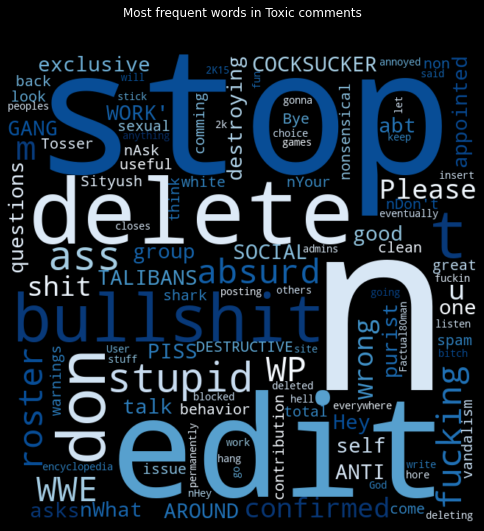

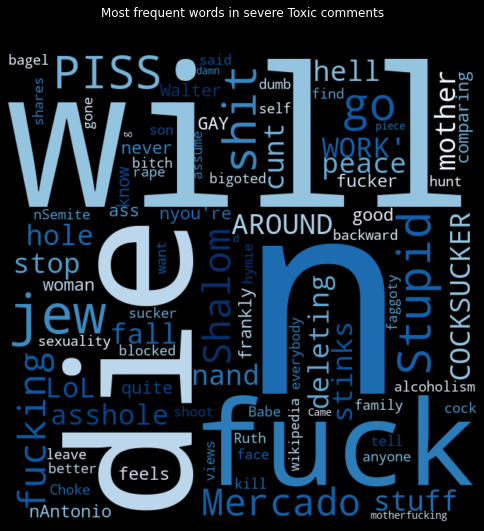

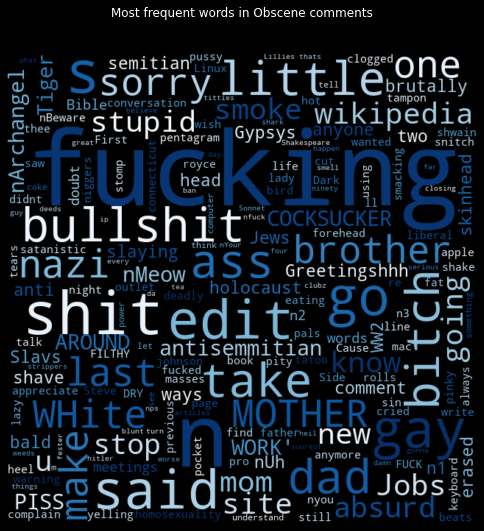

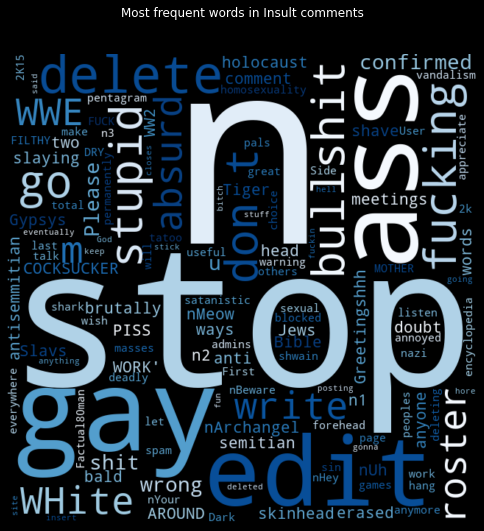

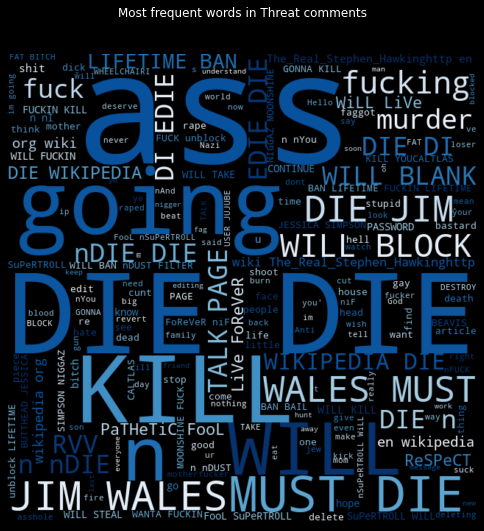

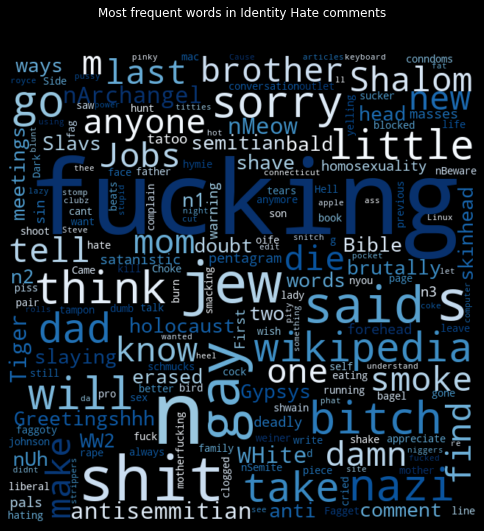

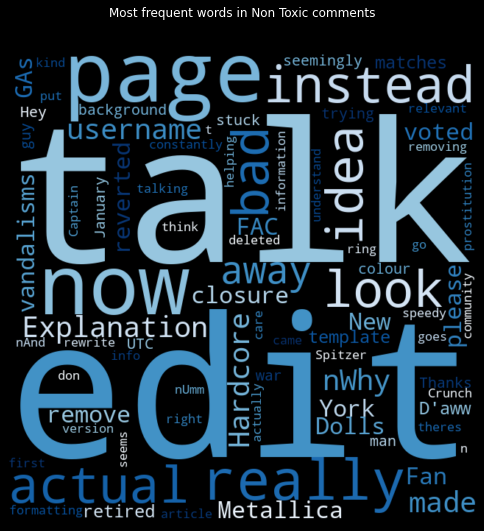

In [10]:
def word_plot(column,text):
    
    comments = data['comment_text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (15, 7), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud.recolor(colormap="Blues"), interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()

word_plot(data['toxic'], "Toxic comments")
word_plot(data['severe_toxic'],"severe Toxic comments")
word_plot(data['obscene'],"Obscene comments")
word_plot(data['insult'],"Insult comments")
word_plot(data['threat'],"Threat comments")
word_plot(data['identity_hate'],"Identity Hate comments")
word_plot(data['non_toxic'],"Non Toxic comments")

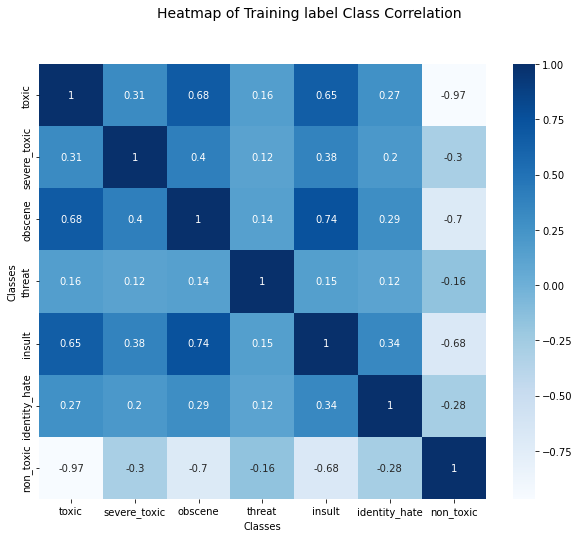

In [11]:
fig = plt.figure(figsize = (10,8))
sns.heatmap(data.corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

## **Data Cleaning and Feature Engineering**

In [12]:
# Conerting all strings into lower case
data["comment_text"] = data["comment_text"].str.lower()

# Replacing non-breaking space with a regular space 
data["comment_text"] = data["comment_text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

# Removing extra spaces in text
data["comment_text"] = data["comment_text"].map(lambda x: re.sub(r"\s\s+", " ",x))

# Removing Hyperlinks from text
data["comment_text"] = data["comment_text"].map(lambda x: re.sub(r"https?://\S+|www\.\S+","",x))

# Removing Special characters 
data["comment_text"] = data["comment_text"].map(lambda x: re.sub(r"[^a-zA-Z0-9\s\"\',:;?!.()]", " ",x))

In [13]:
import gensim.models.keyedvectors as word2vec
import pandas as pd
import gc
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from tqdm import tqdm

In [14]:
train = data
test = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")

In [15]:
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]
y = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']].values

In [16]:
embed_size=100
max_features=20000
max_len=200

In [17]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_train = pad_sequences(list_tokenized_train, maxlen=max_len)
X_test = pad_sequences(list_tokenized_test, maxlen=max_len)

In [18]:
def loadEmbeddingMatrix(typeToLoad):
        # load different embedding file from Kaggle depending on which embedding 
        # matrix we are going to experiment with

        EMBEDDING_FILE='/kaggle/working/wiki-news-300d-1M-subword.vec'
        embed_size = 300
        embeddings_index = dict()
        # Transfer the embedding weights into a dictionary by iterating through every line of the file.
        f = open(EMBEDDING_FILE)
        for line in tqdm(f):
            try:
                # split up line into an indexed array
                values = line.split()
                # first index is word
                word = values[0]
                # store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                # ignore values without headers as word
                if len(coefs)==300:
                    embeddings_index[word] = coefs #300 dimension
                else:
                    continue
            except:
                # split up line into an indexed array
                values = line.split()
                # first index is word or sometimes the second as well
                word = values[1]
                # store the rest of the values in the array as a new array
                coefs = np.asarray(values[2:], dtype='float32')
                print(values[:2])
                print(len(coefs))
                embeddings_index[word] = coefs #300 dimension
        f.close()
        print('Loaded %s word vectors.' % len(embeddings_index))
        #return embeddings_index
            
        gc.collect()
        # We get the mean and standard deviation of the embedding weights so that we could maintain the 
        # same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(embeddings_index.values())
        #np.stack(list(embeddings_index.values()))
        emb_mean, emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        # We are going to set the embedding size to the pretrained dimension as we are replicating it.
        # the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        # With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        # our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            # and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        # finally, return the embedding matrix
        return embedding_matrix

In [19]:
embedding_matrix = loadEmbeddingMatrix('fasttext')

999995it [00:54, 18328.84it/s]
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loaded 999994 word vectors.
total embedded: 85984 common words


In [20]:
embedding_matrix.shape

(190147, 300)

In [21]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1], 
                  weights=[embedding_matrix], trainable=True, input_shape=(max_len,)))
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True, name='lstm_layer')))
model.add(Dropout(0.1))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(7, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-01-22 11:46:35.499852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:46:35.597032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:46:35.597791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:46:35.601409: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          57044100  
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 128)          187392    
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

In [23]:
batch_size = 32
epochs = 4
history = model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

2023-01-22 11:46:38.522224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4


2023-01-22 11:46:40.774265: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4488/4488 [==============================] - 151s 33ms/step - loss: 0.0693 - accuracy: 0.9519 - val_loss: 0.0556 - val_accuracy: 0.9608
Epoch 2/4
4488/4488 [==============================] - 147s 33ms/step - loss: 0.0494 - accuracy: 0.9649 - val_loss: 0.0536 - val_accuracy: 0.9600
Epoch 3/4
4488/4488 [==============================] - 149s 33ms/step - loss: 0.0421 - accuracy: 0.9708 - val_loss: 0.0546 - val_accuracy: 0.9598
Epoch 4/4
4488/4488 [==============================] - 146s 33ms/step - loss: 0.0352 - accuracy: 0.9769 - val_loss: 0.0572 - val_accuracy: 0.9572


In [24]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']

# some predictions
print(list_sentences_test[102])
print(dict(zip(list_classes, model.predict(X_test[10:11])[0])))
print()
print()

# training data
i=201
print(list_sentences_train[i])
print(dict(zip(list_classes, model.predict(X_train[i:i+1])[0])))
print('Actual Values:', train[list_classes].iloc[i].to_dict())

I was merely apologising for my interference ;)
{'toxic': 0.49575552, 'severe_toxic': 0.00014199194, 'obscene': 0.12559554, 'threat': 0.00037173877, 'insult': 0.019666055, 'identity_hate': 0.001066677, 'non_toxic': 0.5097154}


your blatant pov pushing neither of you guys has made any contribution to this italian history article other than to shove your unhistorical unconstructive modern pov in my face. this is a history article. history. have you heard of that? this is the reason why so many people get pissed off about the pedantry and idiocy and triviality of wikipedia. j sus. get a f cking life.
{'toxic': 0.98362917, 'severe_toxic': 0.06779731, 'obscene': 0.89391726, 'threat': 0.0013799085, 'insult': 0.5765569, 'identity_hate': 0.011462662, 'non_toxic': 0.00090842607}
Actual Values: {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 0, 'identity_hate': 0, 'non_toxic': 0}


In [25]:
from keras import metrics